# Hand Gesture Recognition

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#preprocessig">Preprocessing</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#CNN">CNN model</a></li>
<li><a href="#evaluation">Eavluation :: Got 1.0000 F1 Score</a></li>
</ul>

<a id='intro'></a>
## Introduction

##### Dataset Description 

> Dataset Structure: It follows the CSV format with labels and pixel values. Representing a multi-class problem, it includes 24 classes of American Sign Language letters (excluding J and Z, which involve motion gestures).

> Size: The training set comprises 27,455 cases, and the test set includes 7,172 cases. This dataset is approximately half the size of the standard MNIST.

> Image Format: Each training and test case represents a label (0-25) mapped to an alphabetic letter A-Z. The images are 28x28 pixels with grayscale values ranging from 0 to 255.

> **You could find the dataset on kaggle [here](https://www.kaggle.com/datasets/datamunge/sign-language-mnist)**

### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

from tqdm import tqdm
from copy import deepcopy

seed = 1911
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.Generator().manual_seed(42);

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# import os
# current_directory = os.getcwd()

# df_train = pd.read_csv(current_directory + '\DataSource' + '\sign_mnist_train.csv')
# df_test = pd.read_csv(current_directory + '\DataSource' + '\sign_mnist_test.csv')
# df_train.head(2)


df_train = pd.read_csv("/kaggle/input/sign-language-mnist/sign_mnist_train/sign_mnist_train.csv")
df_test = pd.read_csv('/kaggle/input/sign-language-mnist/sign_mnist_test/sign_mnist_test.csv')
df_train.head(2)

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149


> Noticed there is no class 9 > [0 ... 7,8,10, ...] so lets make all labels consistant;
> by make them start from zero to 24

In [3]:
df_train.label = df_train['label'].apply(lambda x: x - 1 if x > 9 else x)
df_test.label = df_test['label'].apply(lambda x: x - 1 if x > 9 else x)

In [4]:
print(f'Shape of Train dataSet is: {df_train.shape}')
print(f'Shape of Validation dataSet is: {df_test.shape}')

Shape of Train dataSet is: (27455, 785)
Shape of Validation dataSet is: (7172, 785)


<a id='preprocessing'></a>
### Data preprocessing

> Making readable labels

In [5]:
import string
Alphabet_labels = list(string.ascii_letters)

> Converting images into shape of w x h

In [6]:
def vector_of_pixels_to_image(pixels):
    imgWidth = int(np.sqrt(pixels.shape[1]))
    
    x = pixels / 255
    print(f'Shape befor resizing: {len(x)}')
    x = x.values.reshape(-1, imgWidth, imgWidth)
    print(f'Shape after resizing: {x.shape}')
    
    return x

In [7]:
x_train, x_val, y_train, y_val = train_test_split(df_train.iloc[:, 1:], df_train.label, random_state=seed)
x_test, y_test = df_test.iloc[:, 1:], df_test.label

In [8]:
x_train = vector_of_pixels_to_image(x_train)
y_train = np.array(y_train)

Shape befor resizing: 20591
Shape after resizing: (20591, 28, 28)


In [9]:
x_val = vector_of_pixels_to_image(x_val)
y_val = np.array(y_val)

Shape befor resizing: 6864
Shape after resizing: (6864, 28, 28)


In [10]:
x_test = vector_of_pixels_to_image(df_test.iloc[:, 1:])
y_test = np.array(df_test.label)

Shape befor resizing: 7172
Shape after resizing: (7172, 28, 28)


<a id='preprocessing'></a>
### Exploratory Data Analysis (EDA)

#### Plotting unique signs

In [11]:
y_unique = np.unique(y_train)
unique_images = []
for label in y_unique:
    indices = np.where(y_train == label)[0]
    unique_images.append(x_train[indices[0]])

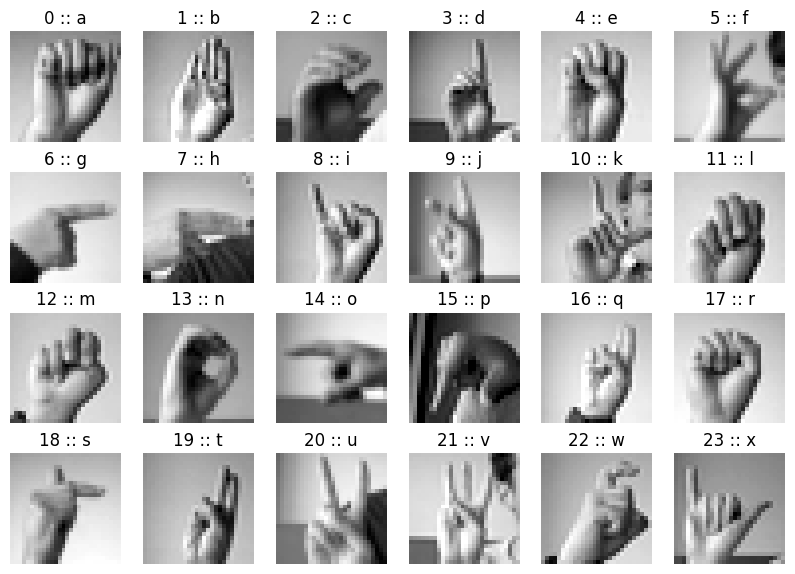

In [12]:
plt.figure(figsize=(10, 7))
n = len(y_unique)
for i in range(n):
    ax = plt.subplot(4, n // 4, i + 1)
    plt.imshow(unique_images[i], cmap='gray')
    plt.title(f'{y_unique[i]} :: {Alphabet_labels[y_unique[i]]}')
    plt.axis('off')

> The distribution of the signs in our training set

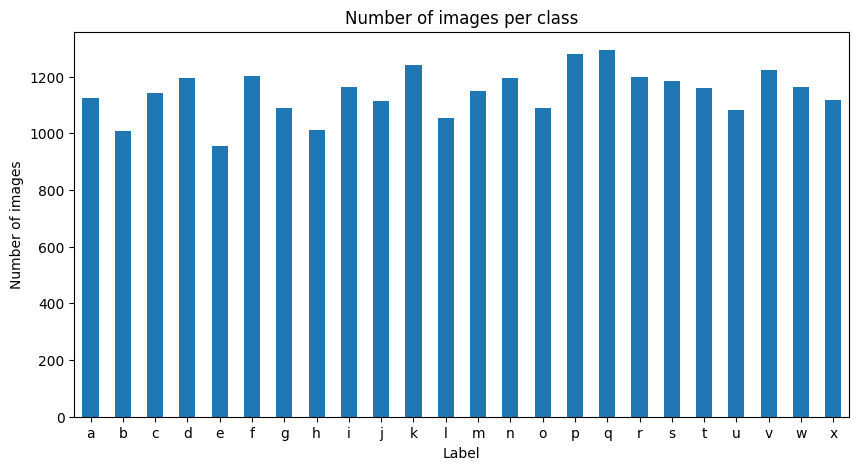

In [13]:
plt.figure(figsize=(10, 5));
df_train.label.value_counts().sort_index().plot(kind='bar');
plt.title('Number of images per class');
plt.ylabel('Number of images');
plt.xlabel('Label');

plt.xticks(ticks=df_train.label.unique(), labels=[Alphabet_labels[label] for label in df_train.label.unique()], rotation=0);

> We notice that the distribution of all labels seems equal.

<a id='CNN'></a>
### CNN Model

In [14]:
from torch.utils.data import Dataset, dataloader

class myDataSet(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
    
    def __len__(self):
        return self.y.shape[0]
    
    def __getitem__(self, index):
        return self.x[index], self.y[index]
    

x_train_tensors = torch.tensor(x_train, dtype=torch.float32).reshape(-1, 1, 28, 28)
y_train_tensors = torch.tensor(y_train, dtype=torch.float32)

x_val_tensors = torch.tensor(x_val, dtype=torch.float32).reshape(-1, 1, 28, 28)
y_val_tensors = torch.tensor(y_val, dtype=torch.float32)

x_test_tensors = torch.tensor(x_test, dtype=torch.float32).reshape(-1, 1, 28, 28)
y_test_tensors = torch.tensor(y_test, dtype=torch.float32)

train_dataset = myDataSet(x_train_tensors, y_train_tensors)
val_dataset = myDataSet(x_val_tensors, y_val_tensors)
test_dataset = myDataSet(x_test_tensors, y_test_tensors)


train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [15]:
class HandGestureModel(nn.Module):
    def __init__(self, dropout_rate=0.25):
        super(HandGestureModel, self).__init__()
        self.network = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout2d(dropout_rate),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout2d(dropout_rate),

            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout2d(dropout_rate),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Dropout2d(dropout_rate),

            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout2d(dropout_rate),

            nn.Flatten(),
            nn.Linear(2304, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(dropout_rate),

            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(dropout_rate),

            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),

            nn.Linear(128, 24)
        )

    def forward(self, xb):
        return self.network(xb)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = HandGestureModel().to(device)

In [16]:
learning_rate = 5e-4
num_epochs = 20
patience = 3 # Number of epochs to wait if validation loss doesn't improve
best_val_loss = float('inf')

counter = 0

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=4e-5)
criterion = nn.CrossEntropyLoss()

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.950)

In [17]:
def train(model, optimizer, criterion, train_loader):
    model.train()
    running_loss = 0.0
    for i, data in tqdm(enumerate(train_loader), desc='Training', total=len(train_loader)):
        optimizer.zero_grad()
        # Forward pass
        x, y = data[0].to(device), data[1].to(device).to(torch.long)
        
        output = model(x)
        
        loss = criterion(output, y)
        
        # Backward pass
        loss.backward()
        
        # Updating parameters
        optimizer.step()

        # Monitoring
        running_loss += loss.item()
        
    return running_loss / len(train_loader)


def evaluate(model, criterion, val_loader):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for data in val_loader:
            x, y = data[0].to(device), data[1].to(device).to(torch.long)
        
            output = model(x)
            # prediction = torch.argmax(output, axis=1)
            
            loss = criterion(output, y)
                
            running_loss += loss.item()
            
    return running_loss / len(val_loader)

In [18]:
train_losses = []
val_losses = []

#Training
for epoch in range(num_epochs):
    # Training loop
    train_loss = train(model, optimizer, criterion, train_loader)
    train_losses.append(train_loss)
    
    # Evaluation loop
    print('Validating ...')
    val_loss = evaluate(model, criterion, val_loader)
    val_losses.append(val_loss)
    
    # Printing and monitoring
    print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')
    
    
    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = deepcopy(model)
        # save_checkpoint(best_model, optimizer, epoch)
        counter = 0
        
    else:
        counter += 1
        if counter >= patience:
            print(f'Validation loss did not improve for {patience} epochs. Stopping early.')
            break
        if counter in range(2, 20, 2):
            scheduler.step()
            print(f"Learning rate decreased!, now is {optimizer.state_dict()['param_groups'][0]['lr']}")

Training: 100%|██████████| 644/644 [00:10<00:00, 61.47it/s] 


Validating ...
Epoch [1/20], Train Loss: 1.2052, Validation Loss: 0.0532


Training: 100%|██████████| 644/644 [00:04<00:00, 132.20it/s]


Validating ...
Epoch [2/20], Train Loss: 0.1036, Validation Loss: 0.0078


Training: 100%|██████████| 644/644 [00:04<00:00, 131.40it/s]


Validating ...
Epoch [3/20], Train Loss: 0.0461, Validation Loss: 0.0018


Training: 100%|██████████| 644/644 [00:04<00:00, 132.17it/s]


Validating ...
Epoch [4/20], Train Loss: 0.0322, Validation Loss: 0.0005


Training: 100%|██████████| 644/644 [00:04<00:00, 131.18it/s]


Validating ...
Epoch [5/20], Train Loss: 0.0285, Validation Loss: 0.0007


Training: 100%|██████████| 644/644 [00:04<00:00, 130.66it/s]


Validating ...
Epoch [6/20], Train Loss: 0.0215, Validation Loss: 0.0002


Training: 100%|██████████| 644/644 [00:04<00:00, 130.19it/s]


Validating ...
Epoch [7/20], Train Loss: 0.0215, Validation Loss: 0.0003


Training: 100%|██████████| 644/644 [00:04<00:00, 131.32it/s]


Validating ...
Epoch [8/20], Train Loss: 0.0154, Validation Loss: 0.0001


Training: 100%|██████████| 644/644 [00:04<00:00, 131.45it/s]


Validating ...
Epoch [9/20], Train Loss: 0.0162, Validation Loss: 0.0002


Training: 100%|██████████| 644/644 [00:04<00:00, 131.56it/s]


Validating ...
Epoch [10/20], Train Loss: 0.0187, Validation Loss: 0.0000


Training: 100%|██████████| 644/644 [00:04<00:00, 131.36it/s]


Validating ...
Epoch [11/20], Train Loss: 0.0138, Validation Loss: 0.0002


Training: 100%|██████████| 644/644 [00:04<00:00, 130.85it/s]


Validating ...
Epoch [12/20], Train Loss: 0.0136, Validation Loss: 0.0000


Training: 100%|██████████| 644/644 [00:04<00:00, 130.70it/s]


Validating ...
Epoch [13/20], Train Loss: 0.0114, Validation Loss: 0.0001


Training: 100%|██████████| 644/644 [00:04<00:00, 131.56it/s]


Validating ...
Epoch [14/20], Train Loss: 0.0078, Validation Loss: 0.0000
Learning rate decreased!, now is 0.000475


Training: 100%|██████████| 644/644 [00:04<00:00, 131.81it/s]


Validating ...
Epoch [15/20], Train Loss: 0.0110, Validation Loss: 0.0000
Validation loss did not improve for 3 epochs. Stopping early.


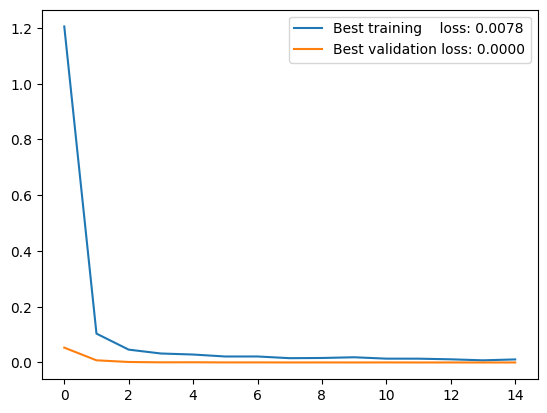

In [19]:
plt.plot(train_losses, label=f'Best training    loss: {min(train_losses):.4f}');
plt.plot(val_losses, label=f'Best validation loss: {min(val_losses):.4f}');
plt.legend();

In [20]:
checkpoint_dir = "./checkpoints"

if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)
    
checkpoint_path = os.path.join(checkpoint_dir, f'Best_model_hg.pt')

torch.save({
    'model': best_model,
    'model_state_dict': best_model.state_dict()
}, checkpoint_path)

---

In [21]:
# checkpoint = torch.load('./checkpoints/Best_model_hg.pt')
# model = checkpoint['model']
# model.load_state_dict(checkpoint['model_state_dict'])

<a id='evaluation'></a>
### Evaluating the model with confusion matrix & f1 score

In [22]:
best_model.eval()

predicted_labels = []
all_true_labels = []
with torch.no_grad():
    for i, data in enumerate(test_loader):
        outputs = best_model(data[0].to(device))
        _, predicted = torch.max(outputs, 1)
        
        predicted_labels.extend(predicted.cpu().numpy())
        all_true_labels.extend(data[1])

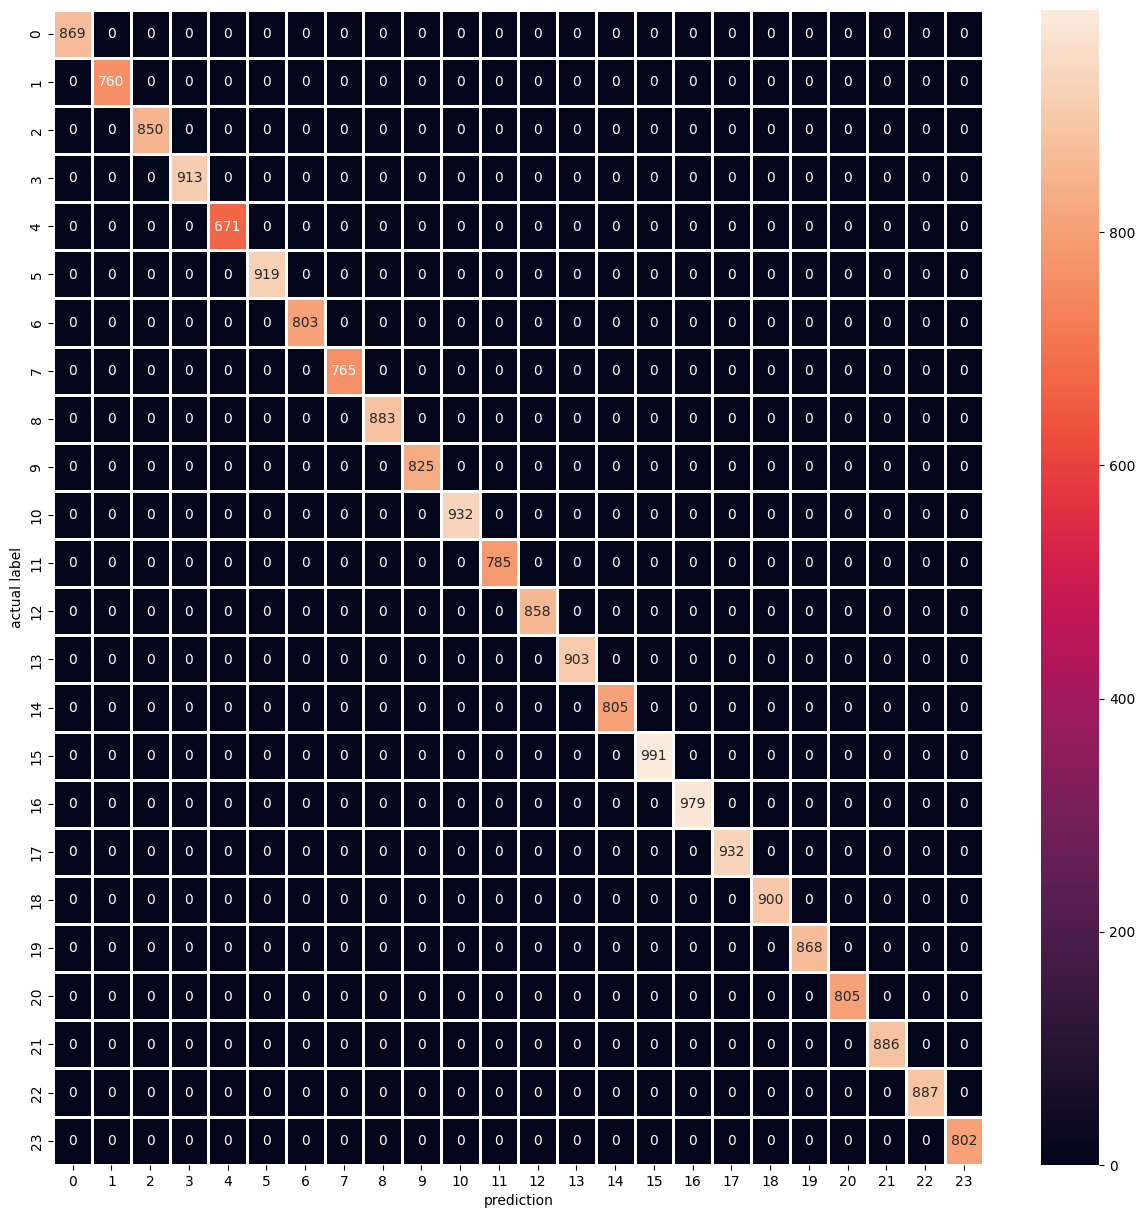

In [23]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

plt.figure(figsize=(15, 15));
cm = confusion_matrix(all_true_labels, predicted_labels);
# sns.heatmap(cm, cmap=sns.cubehelix_palette(as_cmap=True));


ax = sns.heatmap(cm, annot=True, linewidth=1,  fmt='d');
ax.set(xlabel="prediction", ylabel="actual label");
# ax.xaxis.tick_top()

In [24]:
from sklearn.metrics import f1_score

f1_score = f1_score(all_true_labels, predicted_labels, average='weighted')
print(f'The model has f1 score = {f1_score:.05f}')

The model has f1 score = 1.00000


### Testing the model on some data to see its response

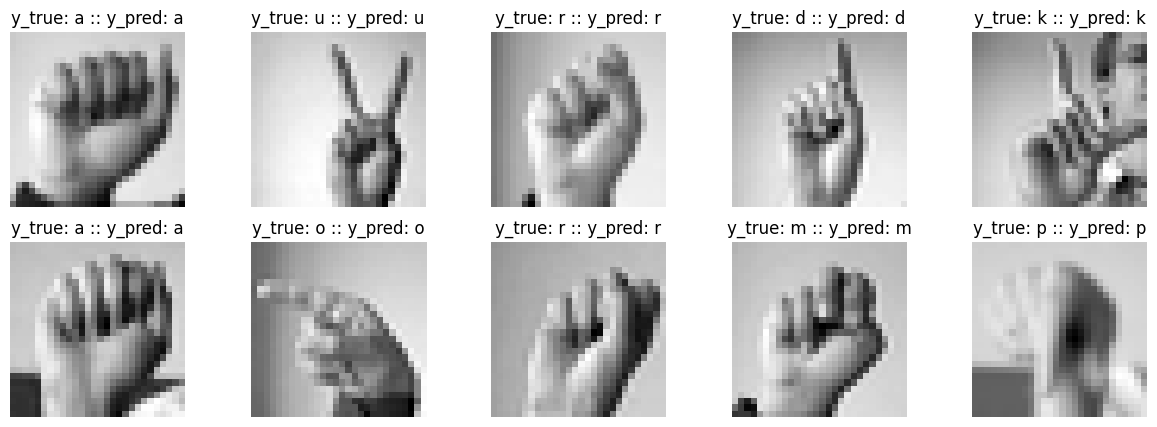

In [25]:
test_gen = iter(test_loader)
images, labels = next(test_gen)

plt.figure(figsize=(15, 5))
for i in range(10):
    ax = plt.subplot(2, 5, i + 1)
    
    img = images[i]
    plt.imshow(img.reshape(28, 28), cmap='gray')
    
    output = best_model(img.to(device).reshape(1, 1, 28, 28))
    y_pred = torch.argmax(output, dim=1).item()
    
    y_true = int(labels[i])
    
    plt.title(f"y_true: {Alphabet_labels[y_true]} :: y_pred: {Alphabet_labels[y_pred]}")
    plt.axis('off')    